<a href="https://colab.research.google.com/github/gabrieladamasceno/MLP-and-Autoencoder-Models-for-Zero-Day-Attack-Detection/blob/main/MLP_All_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/Encoded/Encoded.csv")

Mounted at /content/gdrive


In [ ]:
pip install imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 128.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


In [ ]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [ ]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

In [ ]:
import psutil
import time
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import subprocess
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

# ===== Função para monitorar CPU e memória =====
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

def calcular_energia(cpu_usage, freq_ghz, tempo_exec_s, theta=1.0, z=1e-27):
    freq_hz = freq_ghz * 1e9
    carga = cpu_usage * theta * freq_hz
    energia_joules = z * (carga ** 3) * tempo_exec_s
    return energia_joules

# ===== Callback para monitoramento durante o treinamento =====
class ResourceMonitor(Callback):
    def on_train_begin(self, logs=None):
        self.cpu_usage = []
        self.memory_usage = []
        self.energy_usage = []
        self.start_time = time.time()
        print("\n[Início do Treinamento]")

    def on_epoch_begin(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        print(f"\n[Epoch {epoch + 1} - Início] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        cpu, mem = monitor_resource_usage()
        self.cpu_usage.append(cpu)
        self.memory_usage.append(mem)
        frequencia_cpu_ghz = 2.0
        tempo_execucao_epoca = time.time() - self.start_time
        energy = calcular_energia(cpu, frequencia_cpu_ghz, tempo_execucao_epoca)
        self.energy_usage.append(energy)
        print(f"[Epoch {epoch + 1} - Fim] CPU: {cpu:.2f}%, Memory: {mem:.2f} MB, Energy: {energy:.2f} J")

        # Limpeza de recursos
        gc.collect()
        K.clear_session()

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        avg_cpu = np.mean(self.cpu_usage)
        avg_mem = np.mean(self.memory_usage)

        frequencia_cpu_ghz = 2.0  # Assuma 2.0 GHz se não souber a real

        # Cálculo de energia corrigido
        energia = calcular_energia(avg_cpu, frequencia_cpu_ghz, total_time)

        print("\n[End of Training]")
        print(f"Total time: {total_time:.2f} seconds")
        print(f"Average CPU usage (Training): {avg_cpu:.2f}%")
        print(f"Average memory usage (Training): {avg_mem:.2f} MB")
        print(f"Estimated energy consumption: {energia:.6f} Joules")

        # Armazenar para uso externo
        self.total_time = total_time
        self.avg_cpu = avg_cpu
        self.avg_mem = avg_mem
        self.energia = energia

        self._plot_usage()

    def _plot_usage(self):
        epochs = list(range(1, len(self.cpu_usage) + 1))

        plt.figure(figsize=(14, 5))

        # CPU
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.cpu_usage, marker='o', linestyle='-', color='tab:blue', label='CPU Usage')
        plt.xlabel("Epoch")
        plt.ylabel("CPU Usage (%)")
        plt.title("CPU Consumption (Train)")
        plt.legend()
        plt.grid(True)

        # Memória
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.memory_usage, marker='o', linestyle='-', color='tab:red', label='Memory Usage')
        plt.xlabel("Epoch")
        plt.ylabel("Memory (MB)")
        plt.title("Memory Consumption (Train)")
        plt.legend()
        plt.grid(True)

        #Energia
        plt.subplot(1, 3, 3)
        plt.plot(list(range(1, len(self.energy_usage) + 1)), self.energy_usage, marker='o', linestyle='-', color='tab:green', label='Energy Usage')
        plt.xlabel("Epoch")
        plt.ylabel("Energy (J)")
        plt.title("Energy Consumption (Train)")
        plt.legend()
        plt.grid(True)


        plt.tight_layout()
        plt.savefig("resource_usage_train.png")
        plt.show()
        plt.clf()
        plt.close()


# ===== Monitoramento durante o teste/predição =====
def monitor_test_prediction(model, X_test):
    cpu_usage_test = []
    memory_usage_test = []

    print("\n[Início da Predição/Teste]")
    start_time = time.time()

    step_size = max(1, len(X_test) // 10)
    for i in range(0, len(X_test), step_size):
        end_i = min(i + step_size, len(X_test))
        monitor_cpu, monitor_mem = monitor_resource_usage()
        cpu_usage_test.append(monitor_cpu)
        memory_usage_test.append(monitor_mem)
        _ = model.predict(X_test[i:end_i], verbose=0)

    total_time_test = time.time() - start_time
    avg_cpu_test = np.mean(cpu_usage_test)
    avg_mem_test = np.mean(memory_usage_test)

    frequencia_cpu_ghz = 2.0  # Assuma 2.0 GHz se não souber a real

    # Cálculo de energia
    energia_test = calcular_energia(avg_cpu_test, frequencia_cpu_ghz, total_time_test)

    print("\n[End of Prediction/Test]")
    print(f"Total time: {total_time_test:.2f} seconds")
    print(f"Average CPU usage (Test): {avg_cpu_test:.2f}%")
    print(f"Average memory usage (Test): {avg_mem_test:.2f} MB")
    print(f"Estimated energy consumption: {energia_test:.6f} Joules")

    # Gráficos
    plt.figure(figsize=(14, 5))

    # CPU
    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(cpu_usage_test) + 1), cpu_usage_test, marker='o', linestyle='-', color='tab:blue', label='CPU Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("CPU Usage (%)")
    plt.title("CPU Consumption (Test)")
    plt.legend()
    plt.grid(True)

    # Memória
    plt.subplot(1, 3, 2)
    plt.plot(range(1, len(memory_usage_test) + 1), memory_usage_test, marker='o', linestyle='-', color='tab:red', label='Memory Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("Memory (MB)")
    plt.title("Memory Consumption (Test)")
    plt.legend()
    plt.grid(True)

    #Energia
    plt.subplot(1, 3, 3)
    energia_plot = [energia_test] * len(cpu_usage_test)
    plt.plot(range(1, len(cpu_usage_test) + 1), energia_plot, marker='o', linestyle='-', color='tab:green', label='Energy Usage (Test)')
    plt.xlabel("Prediction Block")
    plt.ylabel("Energy (J)")
    plt.title("Energy Consumption (Test)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("resource_usage_test.png")
    plt.show()
    plt.clf()
    plt.close()

    return {
    'total_time': total_time_test,
    'avg_cpu': avg_cpu_test,
    'avg_mem': avg_mem_test,
    'energia': energia_test
    }

resource_monitor = ResourceMonitor()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


====== Zero-Day: ICMPFlood ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 3155.82 MB
[Epoch 1 - Fim] CPU: 1.70%, Memory: 3276.25 MB, Energy: 852.51 J

[Epoch 2 - Início] CPU: 1.40%, Memory: 3276.30 MB
[Epoch 2 - Fim] CPU: 2.50%, Memory: 3339.55 MB, Energy: 5363.42 J

[Epoch 3 - Início] CPU: 1.70%, Memory: 3339.61 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3372.22 MB, Energy: 0.00 J

[Epoch 4 - Início] CPU: 0.60%, Memory: 3372.21 MB
[Epoch 4 - Fim] CPU: 1.00%, Memory: 3386.68 MB, Energy: 677.99 J

[Epoch 5 - Início] CPU: 1.50%, Memory: 3386.68 MB
[Epoch 5 - Fim] CPU: 0.10%, Memory: 3400.83 MB, Energy: 0.85 J

[Epoch 6 - Início] CPU: 1.00%, Memory: 3400.83 MB
[Epoch 6 - Fim] CPU: 0.10%, Memory: 3414.91 MB, Energy: 1.02 J

[Epoch 7 - Início] CPU: 0.00%, Memory: 3414.91 MB
[Epoch 7 - Fim] CPU: 0.30%, Memory: 3429.05 MB, Energy: 31.99 J

[Epoch 8 - Início] CPU: 0.10%, Memory: 3429.04 MB
[Epoch 8 - Fim] CPU: 0.50%, Memory: 3441.41 MB, Energy: 169.30 J

[Epoch 9 - Início

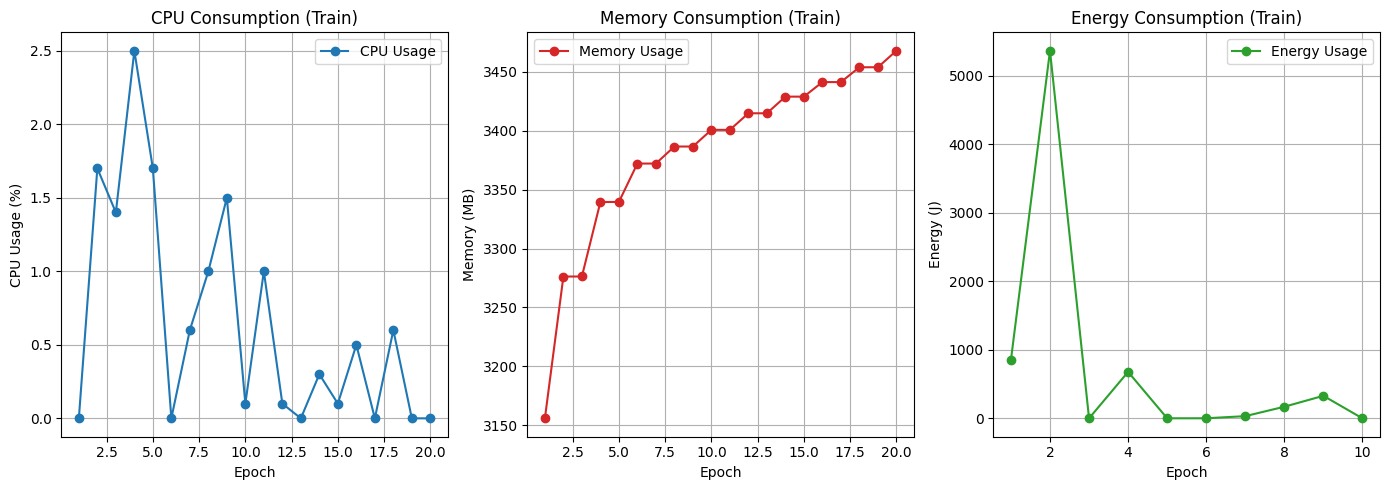

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 840us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 10.77 seconds
Average CPU usage (Test): 0.40%
Average memory usage (Test): 3240.45 MB
Estimated energy consumption: 5.515072 Joules


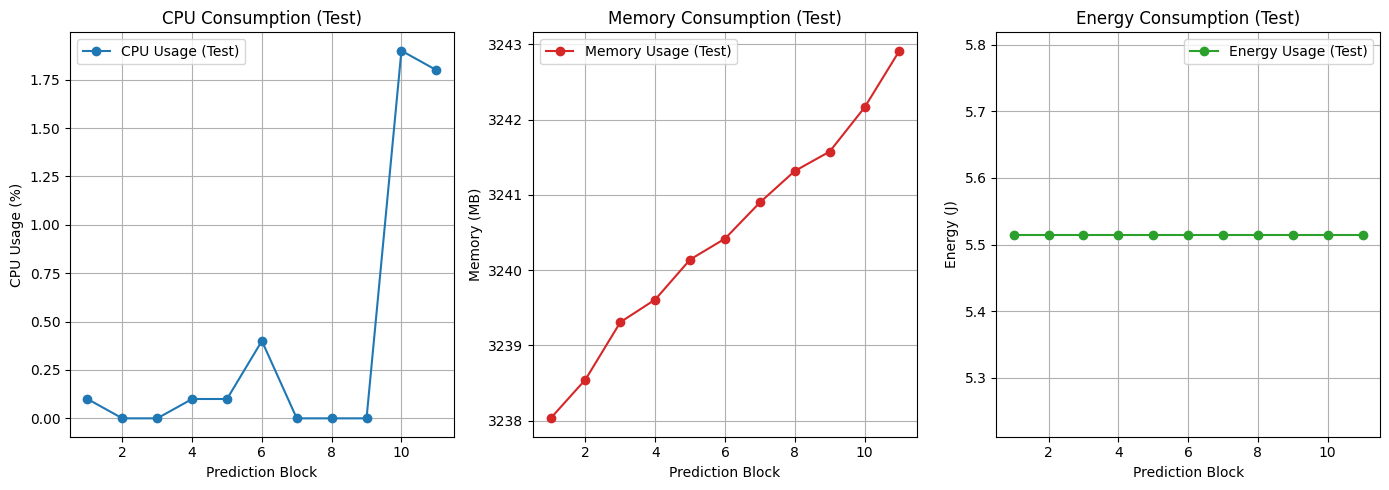

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.06 seconds
Average CPU usage (Test): 0.44%
Average memory usage (Test): 3172.78 MB
Estimated energy consumption: 1.369809 Joules


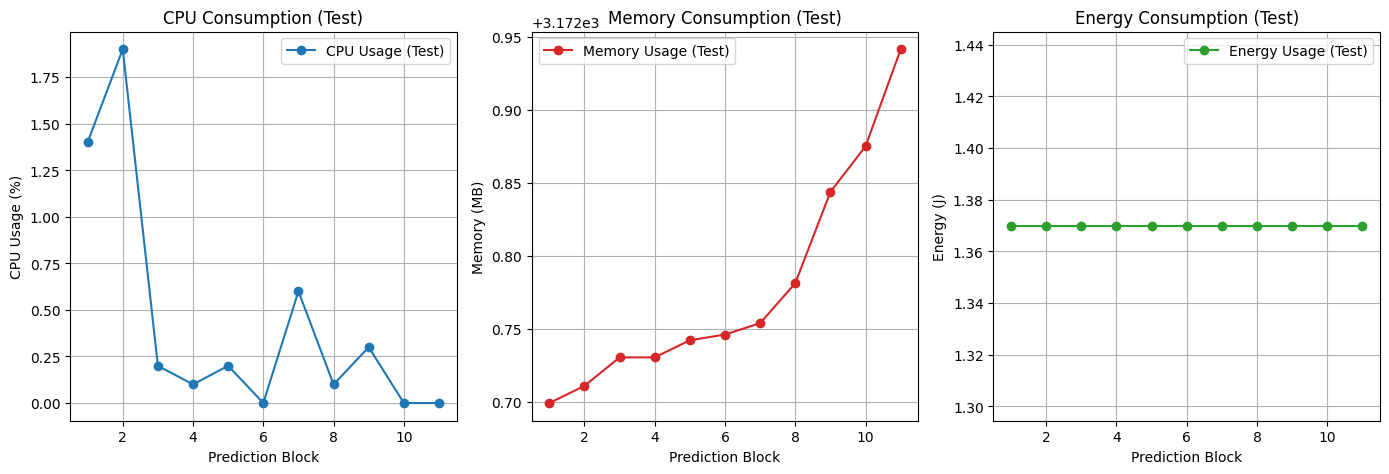


====== Zero-Day: UDPFlood ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 1.20%, Memory: 3329.07 MB
[Epoch 1 - Fim] CPU: 0.50%, Memory: 3173.77 MB, Energy: 15.25 J

[Epoch 2 - Início] CPU: 0.00%, Memory: 3173.80 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3223.32 MB, Energy: 0.00 J

[Epoch 3 - Início] CPU: 0.10%, Memory: 3223.32 MB
[Epoch 3 - Fim] CPU: 0.10%, Memory: 3237.65 MB, Energy: 0.35 J

[Epoch 4 - Início] CPU: 0.10%, Memory: 3237.64 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3246.72 MB, Energy: 0.00 J

[Epoch 5 - Início] CPU: 0.00%, Memory: 3246.71 MB
[Epoch 5 - Fim] CPU: 1.10%, Memory: 3256.34 MB, Energy: 772.81 J

[Epoch 6 - Início] CPU: 1.10%, Memory: 3256.34 MB
[Epoch 6 - Fim] CPU: 0.80%, Memory: 3270.57 MB, Energy: 356.20 J

[Epoch 7 - Início] CPU: 0.00%, Memory: 3270.56 MB
[Epoch 7 - Fim] CPU: 0.10%, Memory: 3279.48 MB, Energy: 0.81 J

[Epoch 8 - Início] CPU: 0.80%, Memory: 3279.48 MB
[Epoch 8 - Fim] CPU: 0.20%, Memory: 3290.91 MB, Energy: 7.44 J

[Epoch 9 - Início] CPU:

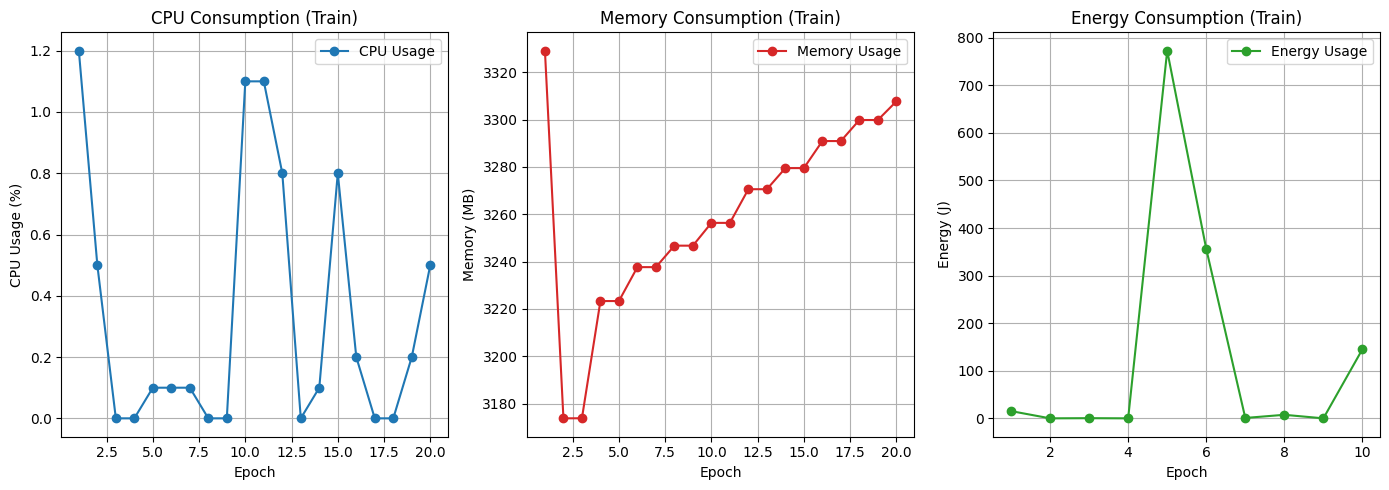

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 7s 859us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 10.90 seconds
Average CPU usage (Test): 0.48%
Average memory usage (Test): 3281.45 MB
Estimated energy consumption: 9.750222 Joules


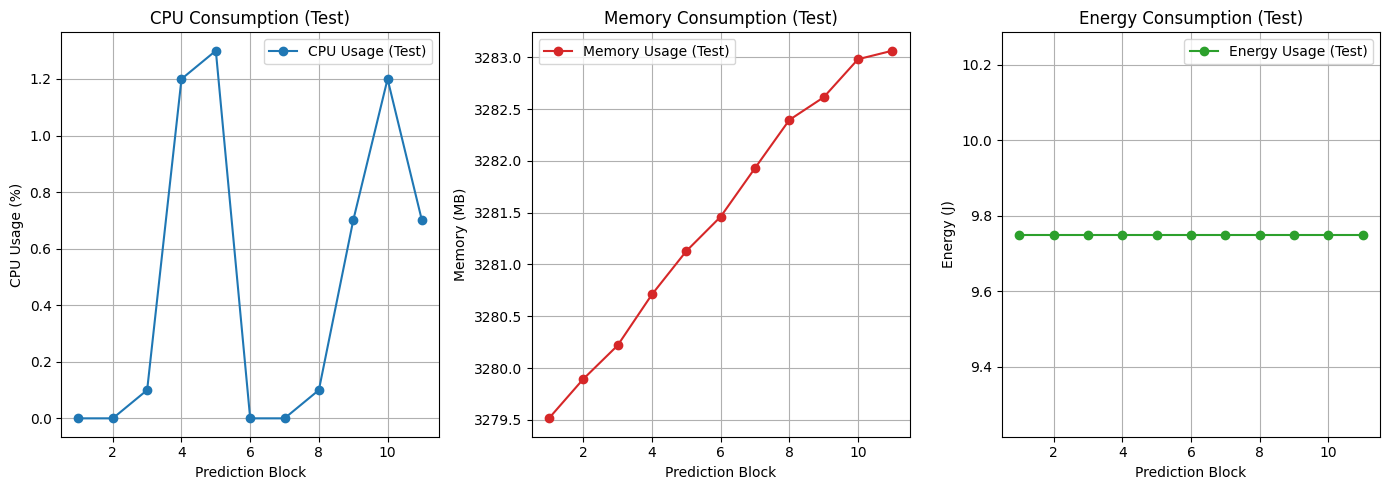

2857/2857 ━━━━━━━━━━━━━━━━━━━━ 2s 853us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 5.44 seconds
Average CPU usage (Test): 0.69%
Average memory usage (Test): 3284.63 MB
Estimated energy consumption: 14.353493 Joules


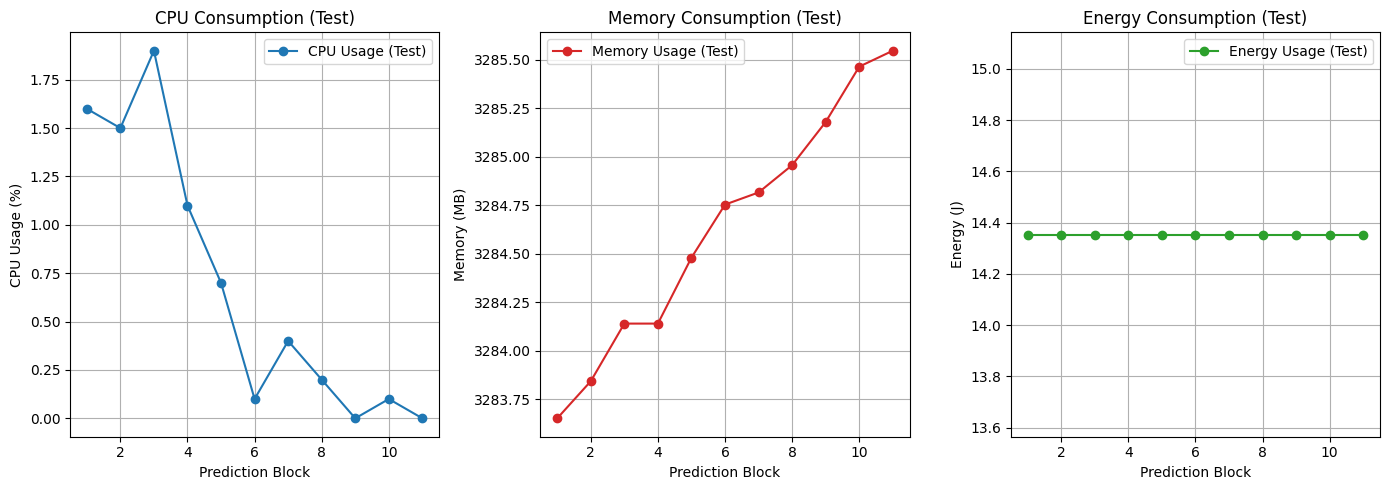


====== Zero-Day: SYNFlood ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.00%, Memory: 3795.19 MB
[Epoch 1 - Fim] CPU: 1.10%, Memory: 3555.63 MB, Energy: 238.77 J

[Epoch 2 - Início] CPU: 1.10%, Memory: 3555.64 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3576.41 MB, Energy: 0.00 J

[Epoch 3 - Início] CPU: 0.10%, Memory: 3576.40 MB
[Epoch 3 - Fim] CPU: 0.70%, Memory: 3612.13 MB, Energy: 178.83 J

[Epoch 4 - Início] CPU: 0.00%, Memory: 3612.12 MB
[Epoch 4 - Fim] CPU: 1.10%, Memory: 3624.15 MB, Energy: 929.26 J

[Epoch 5 - Início] CPU: 0.00%, Memory: 3624.14 MB
[Epoch 5 - Fim] CPU: 1.20%, Memory: 3639.78 MB, Energy: 1500.98 J

[Epoch 6 - Início] CPU: 1.50%, Memory: 3639.77 MB
[Epoch 6 - Fim] CPU: 0.10%, Memory: 3651.85 MB, Energy: 1.04 J

[Epoch 7 - Início] CPU: 0.00%, Memory: 3651.84 MB
[Epoch 7 - Fim] CPU: 0.10%, Memory: 3661.97 MB, Energy: 1.22 J

[Epoch 8 - Início] CPU: 0.00%, Memory: 3661.96 MB
[Epoch 8 - Fim] CPU: 0.10%, Memory: 3672.12 MB, Energy: 1.39 J

[Epoch 9 - Início] 

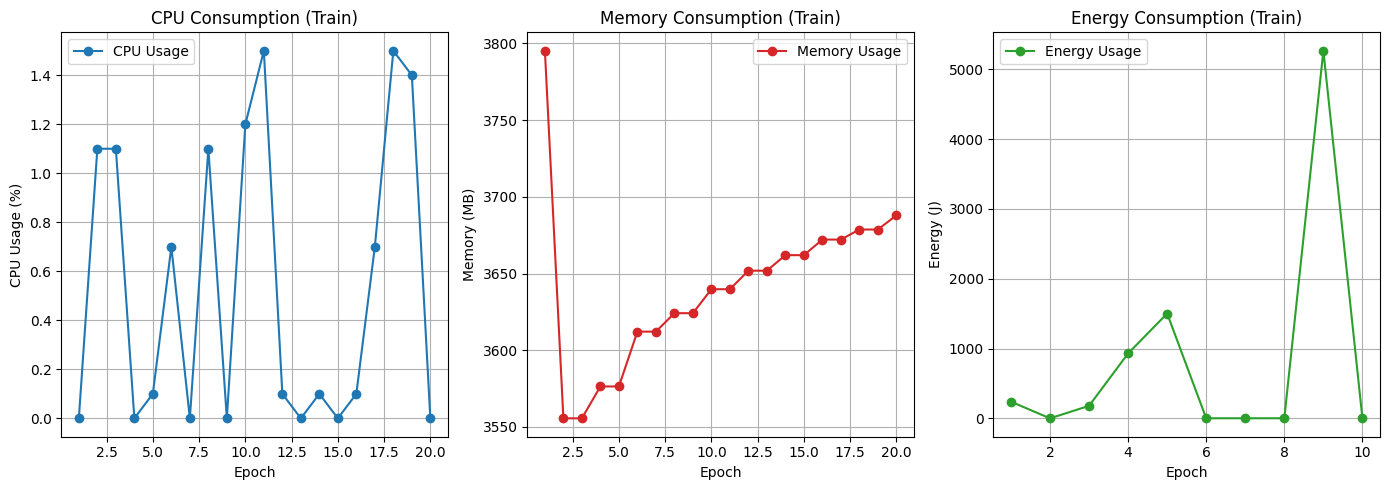

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 7s 851us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 10.98 seconds
Average CPU usage (Test): 0.36%
Average memory usage (Test): 3633.65 MB
Estimated energy consumption: 4.225619 Joules


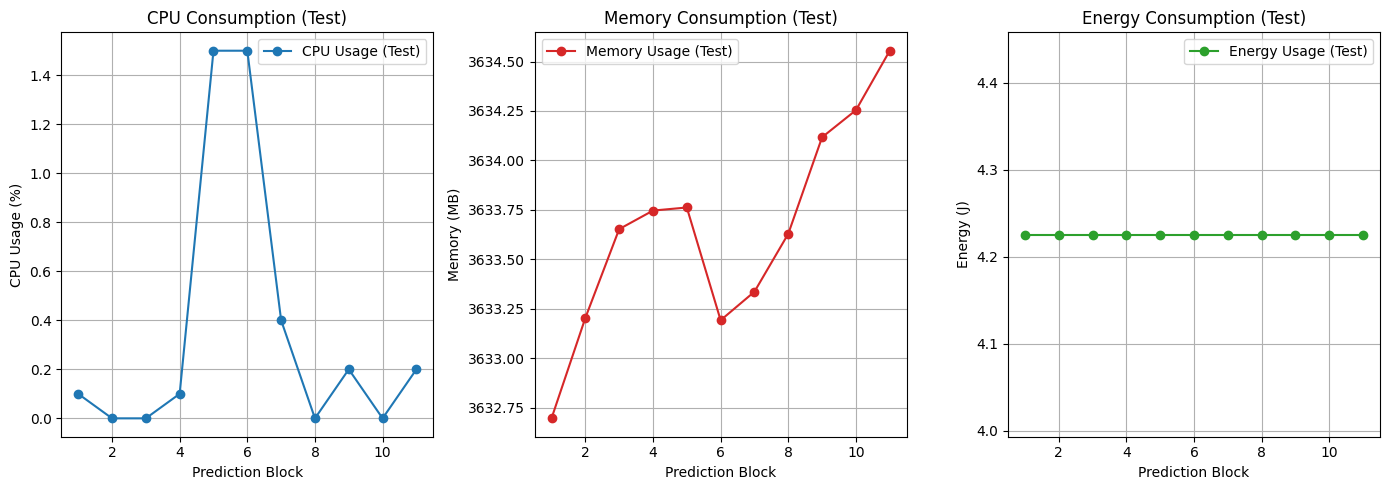

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.16 seconds
Average CPU usage (Test): 0.15%
Average memory usage (Test): 3381.05 MB
Estimated energy consumption: 0.053294 Joules


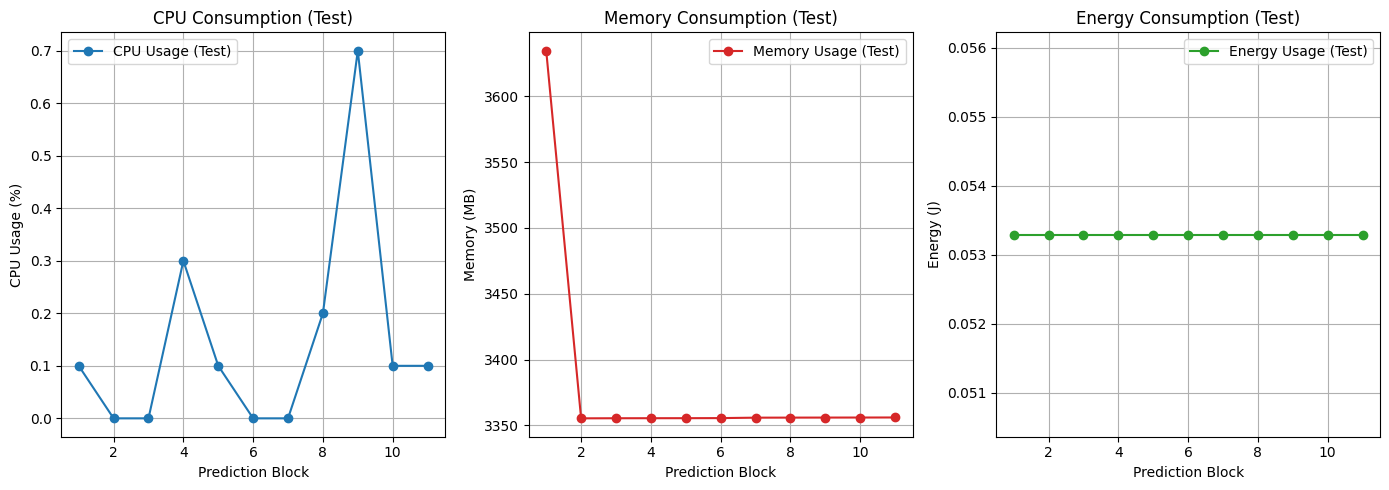


====== Zero-Day: SYNScan ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.10%, Memory: 3809.48 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 3636.20 MB, Energy: 0.00 J

[Epoch 2 - Início] CPU: 0.20%, Memory: 3636.24 MB
[Epoch 2 - Fim] CPU: 0.40%, Memory: 3659.13 MB, Energy: 22.25 J

[Epoch 3 - Início] CPU: 0.10%, Memory: 3659.12 MB
[Epoch 3 - Fim] CPU: 1.20%, Memory: 3679.74 MB, Energy: 894.87 J

[Epoch 4 - Início] CPU: 1.10%, Memory: 3679.73 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3689.89 MB, Energy: 0.00 J

[Epoch 5 - Início] CPU: 0.10%, Memory: 3689.88 MB
[Epoch 5 - Fim] CPU: 0.10%, Memory: 3696.82 MB, Energy: 0.86 J

[Epoch 6 - Início] CPU: 0.30%, Memory: 3696.81 MB
[Epoch 6 - Fim] CPU: 1.20%, Memory: 3710.07 MB, Energy: 1785.74 J

[Epoch 7 - Início] CPU: 0.10%, Memory: 3710.06 MB
[Epoch 7 - Fim] CPU: 1.00%, Memory: 3730.19 MB, Energy: 1200.77 J

[Epoch 8 - Início] CPU: 1.50%, Memory: 3730.18 MB
[Epoch 8 - Fim] CPU: 0.00%, Memory: 3748.57 MB, Energy: 0.00 J

[Epoch 9 - Início] C

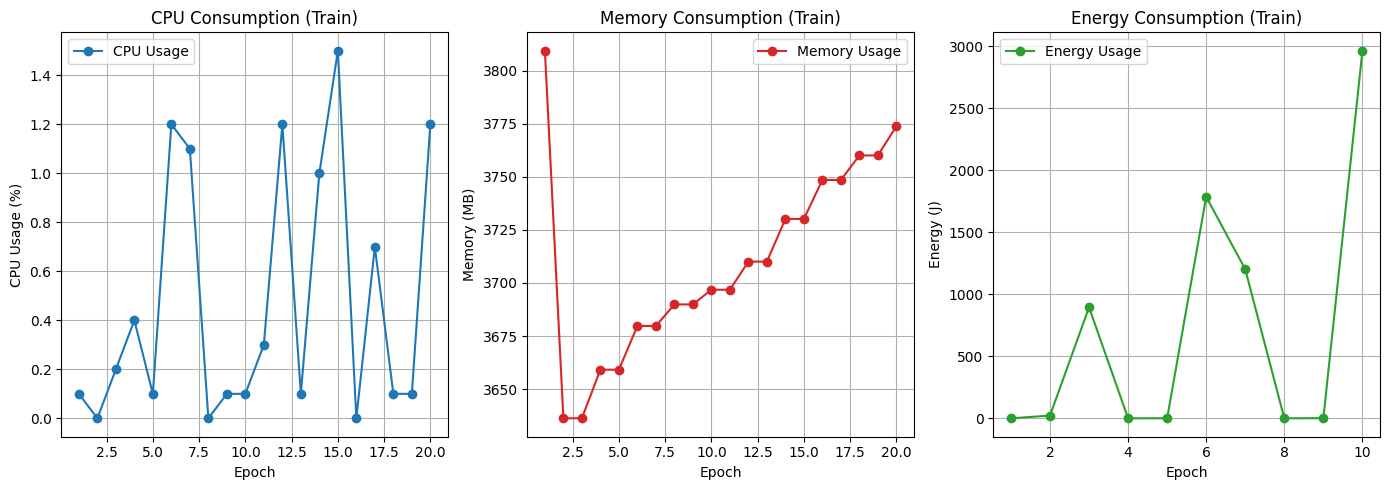

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 7s 864us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 11.02 seconds
Average CPU usage (Test): 0.26%
Average memory usage (Test): 3526.38 MB
Estimated energy consumption: 1.615720 Joules


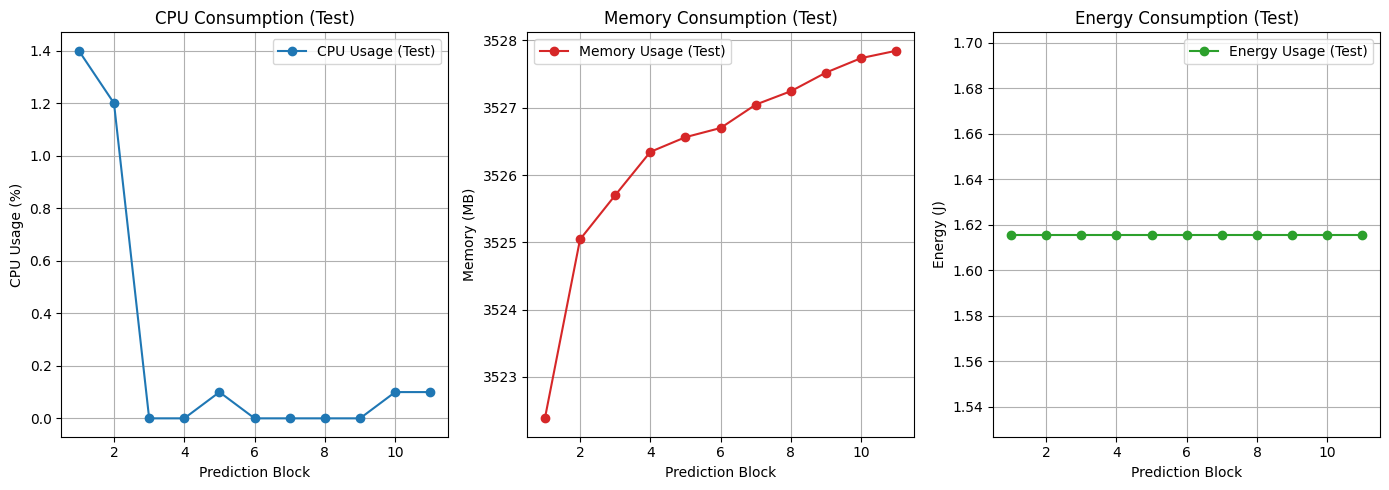

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.20 seconds
Average CPU usage (Test): 1.27%
Average memory usage (Test): 3528.33 MB
Estimated energy consumption: 36.260910 Joules


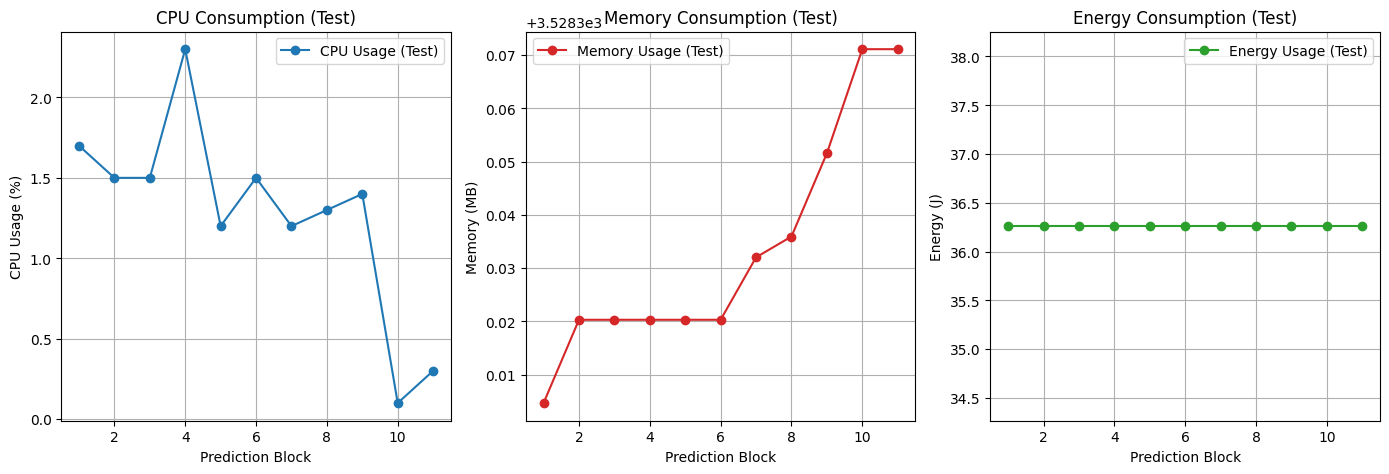


====== Zero-Day: HTTPFlood ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.90%, Memory: 3784.25 MB
[Epoch 1 - Fim] CPU: 0.10%, Memory: 3629.66 MB, Energy: 0.15 J

[Epoch 2 - Início] CPU: 0.20%, Memory: 3629.68 MB
[Epoch 2 - Fim] CPU: 0.20%, Memory: 3640.20 MB, Energy: 2.32 J

[Epoch 3 - Início] CPU: 0.20%, Memory: 3640.20 MB
[Epoch 3 - Fim] CPU: 0.10%, Memory: 3651.05 MB, Energy: 0.43 J

[Epoch 4 - Início] CPU: 0.30%, Memory: 3651.05 MB
[Epoch 4 - Fim] CPU: 0.10%, Memory: 3661.82 MB, Energy: 0.58 J

[Epoch 5 - Início] CPU: 0.10%, Memory: 3661.81 MB
[Epoch 5 - Fim] CPU: 0.30%, Memory: 3679.95 MB, Energy: 19.44 J

[Epoch 6 - Início] CPU: 0.00%, Memory: 3679.95 MB
[Epoch 6 - Fim] CPU: 0.80%, Memory: 3688.97 MB, Energy: 440.94 J

[Epoch 7 - Início] CPU: 0.10%, Memory: 3688.96 MB
[Epoch 7 - Fim] CPU: 1.10%, Memory: 3696.80 MB, Energy: 1333.17 J

[Epoch 8 - Início] CPU: 1.50%, Memory: 3696.80 MB
[Epoch 8 - Fim] CPU: 0.00%, Memory: 3707.02 MB, Energy: 0.00 J

[Epoch 9 - Início] CP

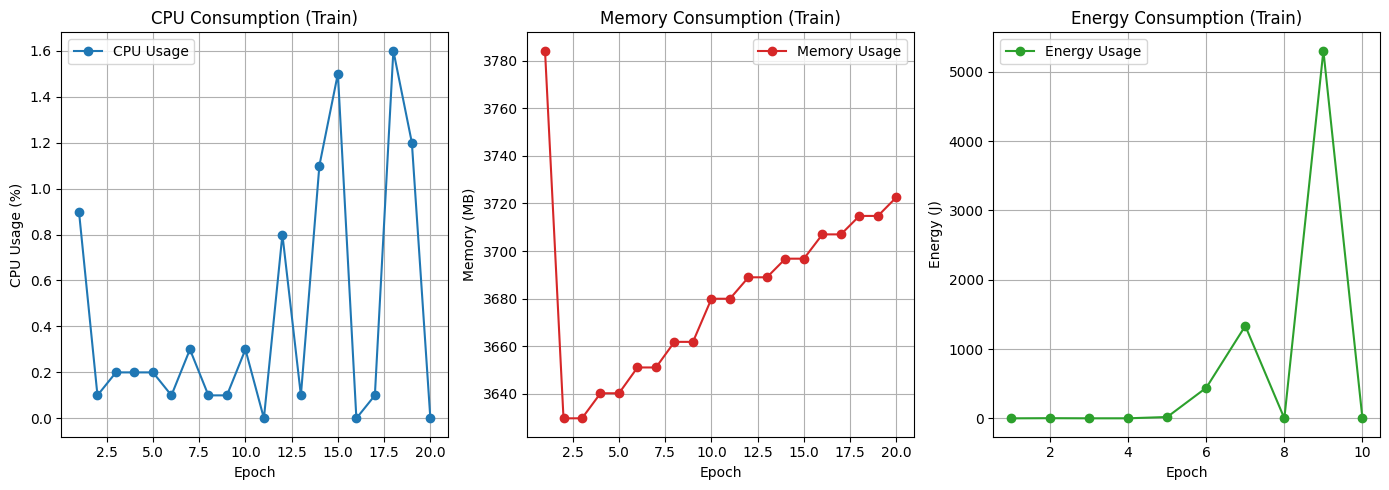

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 843us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 10.85 seconds
Average CPU usage (Test): 0.27%
Average memory usage (Test): 3709.75 MB
Estimated energy consumption: 1.760995 Joules


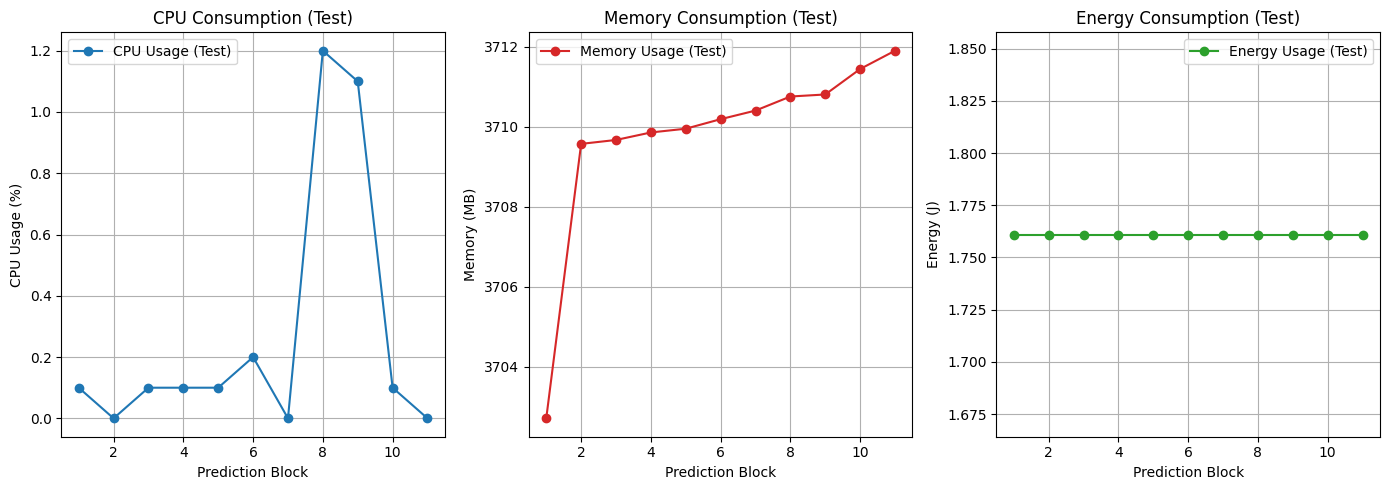

881/881 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 3.05 seconds
Average CPU usage (Test): 0.12%
Average memory usage (Test): 3560.01 MB
Estimated energy consumption: 0.040274 Joules


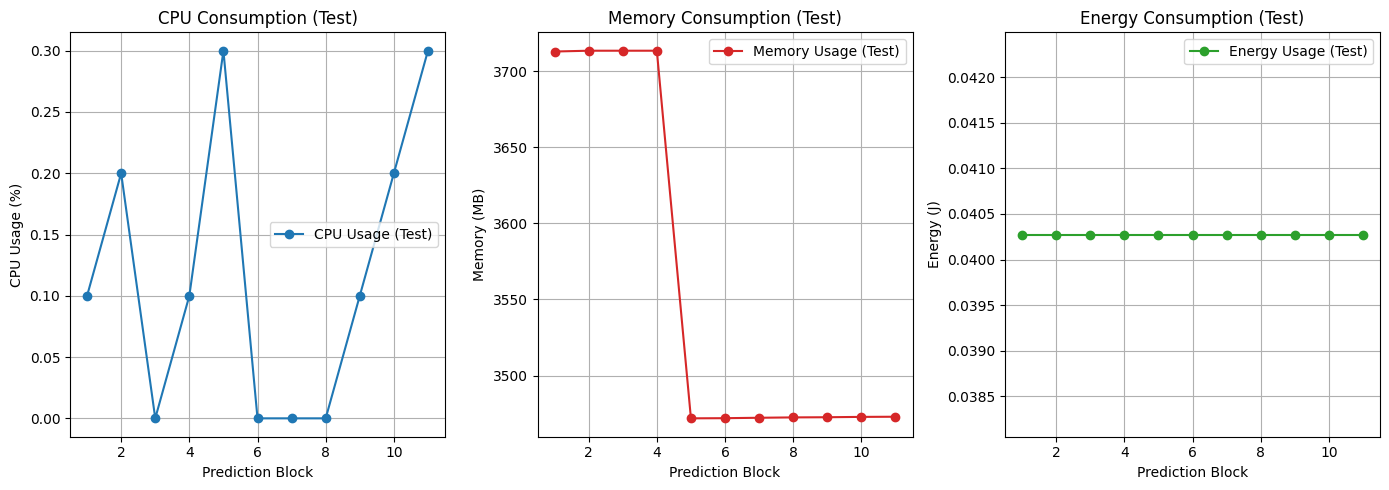


====== Zero-Day: UDPScan ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 1.00%, Memory: 3924.41 MB
[Epoch 1 - Fim] CPU: 0.00%, Memory: 3826.03 MB, Energy: 0.00 J

[Epoch 2 - Início] CPU: 0.50%, Memory: 3826.05 MB
[Epoch 2 - Fim] CPU: 1.60%, Memory: 3848.54 MB, Energy: 1436.80 J

[Epoch 3 - Início] CPU: 0.10%, Memory: 3848.53 MB
[Epoch 3 - Fim] CPU: 0.00%, Memory: 3858.83 MB, Energy: 0.00 J

[Epoch 4 - Início] CPU: 0.70%, Memory: 3858.82 MB
[Epoch 4 - Fim] CPU: 0.10%, Memory: 3861.97 MB, Energy: 0.70 J

[Epoch 5 - Início] CPU: 0.30%, Memory: 3861.96 MB
[Epoch 5 - Fim] CPU: 0.70%, Memory: 3871.89 MB, Energy: 299.28 J

[Epoch 6 - Início] CPU: 0.30%, Memory: 3871.89 MB
[Epoch 6 - Fim] CPU: 1.10%, Memory: 3882.54 MB, Energy: 1391.27 J

[Epoch 7 - Início] CPU: 0.20%, Memory: 3882.53 MB
[Epoch 7 - Fim] CPU: 0.90%, Memory: 3895.59 MB, Energy: 887.01 J

[Epoch 8 - Início] CPU: 0.20%, Memory: 3895.59 MB
[Epoch 8 - Fim] CPU: 0.10%, Memory: 3908.72 MB, Energy: 1.38 J

[Epoch 9 - Início] 

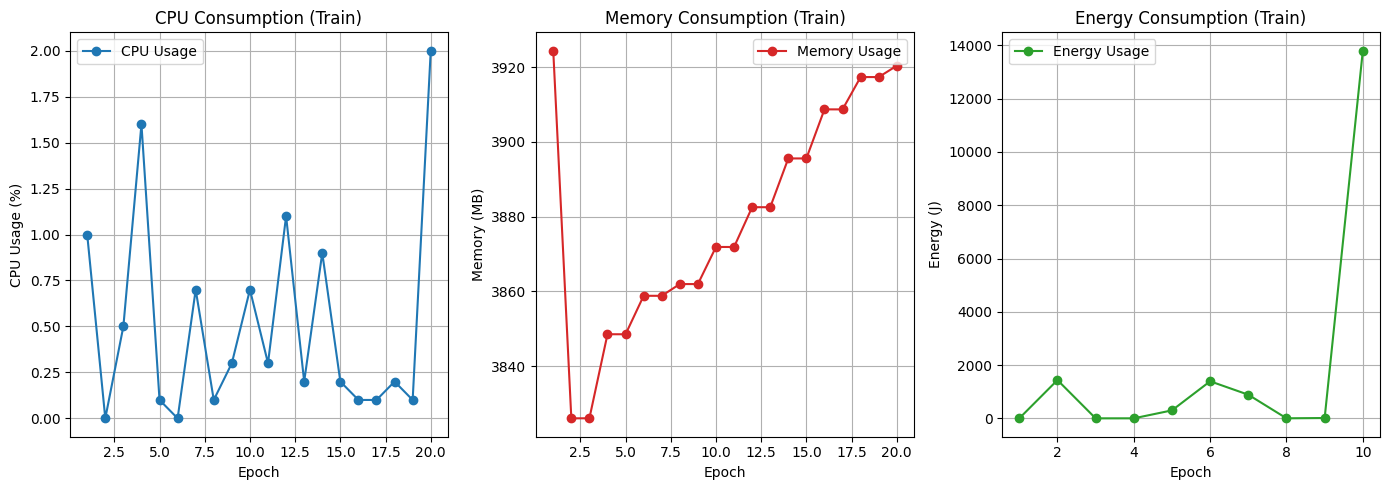

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 813us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 10.75 seconds
Average CPU usage (Test): 0.26%
Average memory usage (Test): 3698.28 MB
Estimated energy consumption: 1.576218 Joules


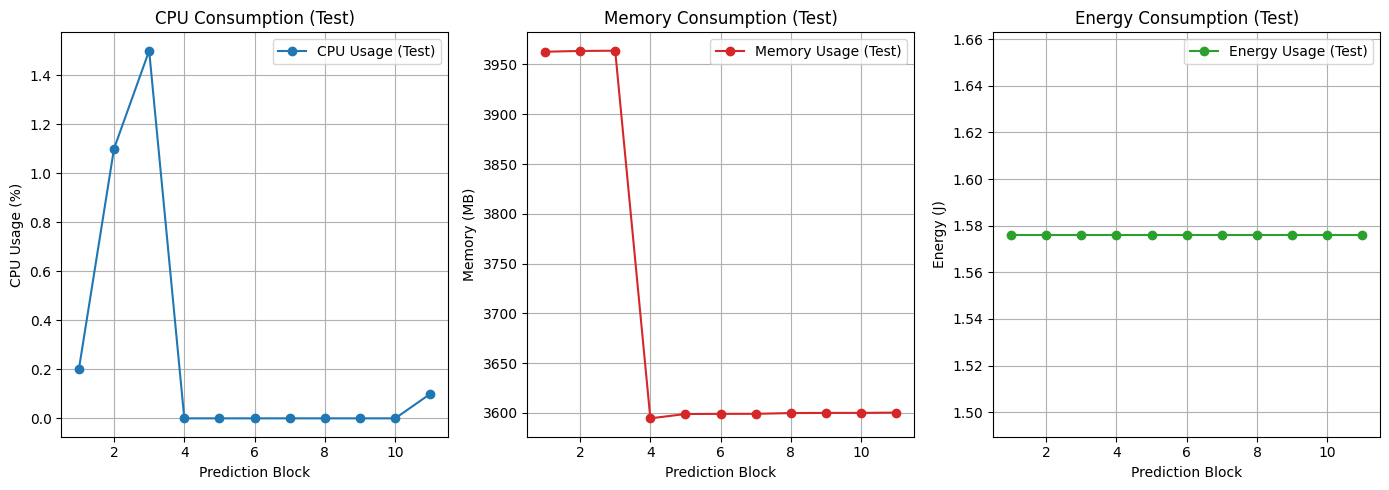

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.15 seconds
Average CPU usage (Test): 0.67%
Average memory usage (Test): 3608.29 MB
Estimated energy consumption: 5.244656 Joules


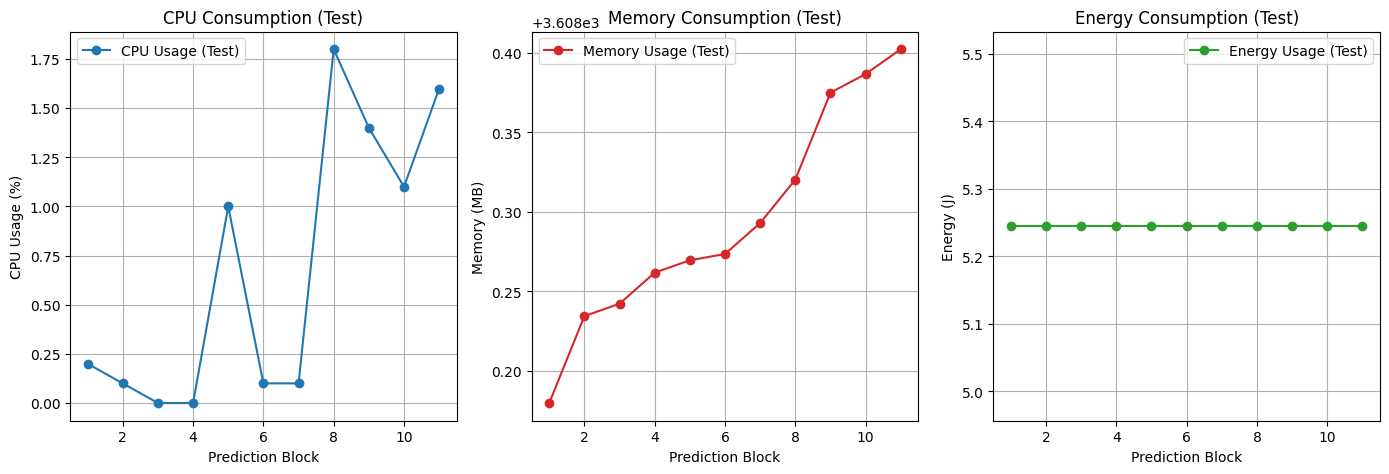


====== Zero-Day: TCPConnectScan ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 1.00%, Memory: 4182.60 MB
[Epoch 1 - Fim] CPU: 0.20%, Memory: 3856.07 MB, Energy: 1.37 J

[Epoch 2 - Início] CPU: 0.20%, Memory: 3856.08 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3904.02 MB, Energy: 0.00 J

[Epoch 3 - Início] CPU: 0.10%, Memory: 3904.02 MB
[Epoch 3 - Fim] CPU: 1.30%, Memory: 3925.64 MB, Energy: 1138.61 J

[Epoch 4 - Início] CPU: 0.10%, Memory: 3925.63 MB
[Epoch 4 - Fim] CPU: 0.10%, Memory: 3935.07 MB, Energy: 0.69 J

[Epoch 5 - Início] CPU: 0.40%, Memory: 3935.06 MB
[Epoch 5 - Fim] CPU: 1.00%, Memory: 3943.32 MB, Energy: 864.23 J

[Epoch 6 - Início] CPU: 0.20%, Memory: 3943.31 MB
[Epoch 6 - Fim] CPU: 0.10%, Memory: 3951.58 MB, Energy: 1.04 J

[Epoch 7 - Início] CPU: 0.10%, Memory: 3951.57 MB
[Epoch 7 - Fim] CPU: 1.40%, Memory: 3953.79 MB, Energy: 3325.25 J

[Epoch 8 - Início] CPU: 0.40%, Memory: 3953.78 MB
[Epoch 8 - Fim] CPU: 0.00%, Memory: 3963.20 MB, Energy: 0.00 J

[Epoch 9 - Iní

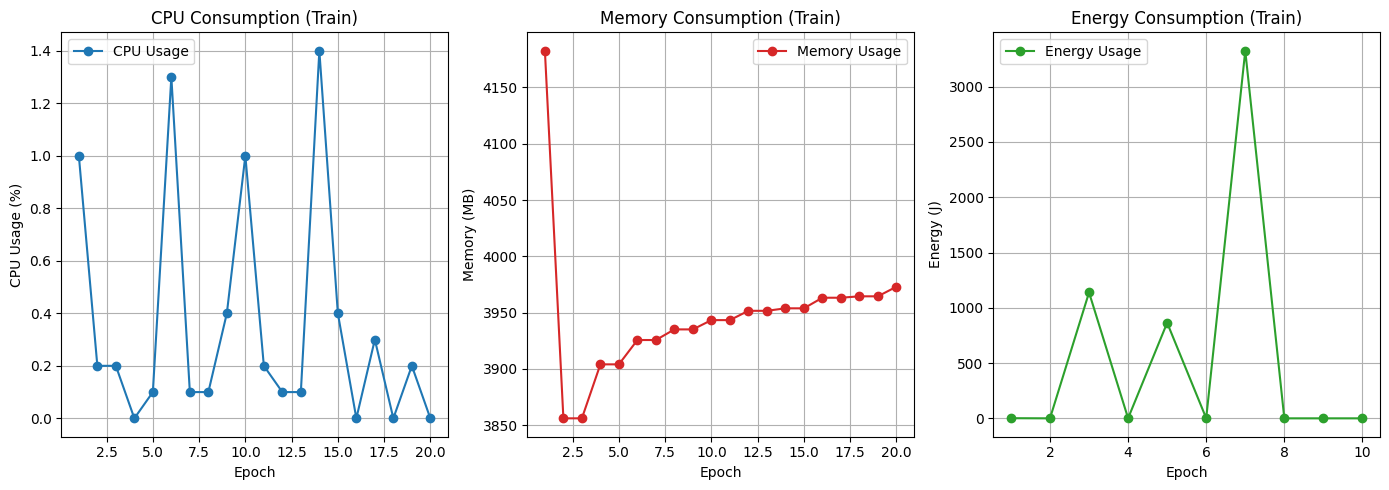

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 7s 853us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 10.88 seconds
Average CPU usage (Test): 0.66%
Average memory usage (Test): 3833.07 MB
Estimated energy consumption: 25.443671 Joules


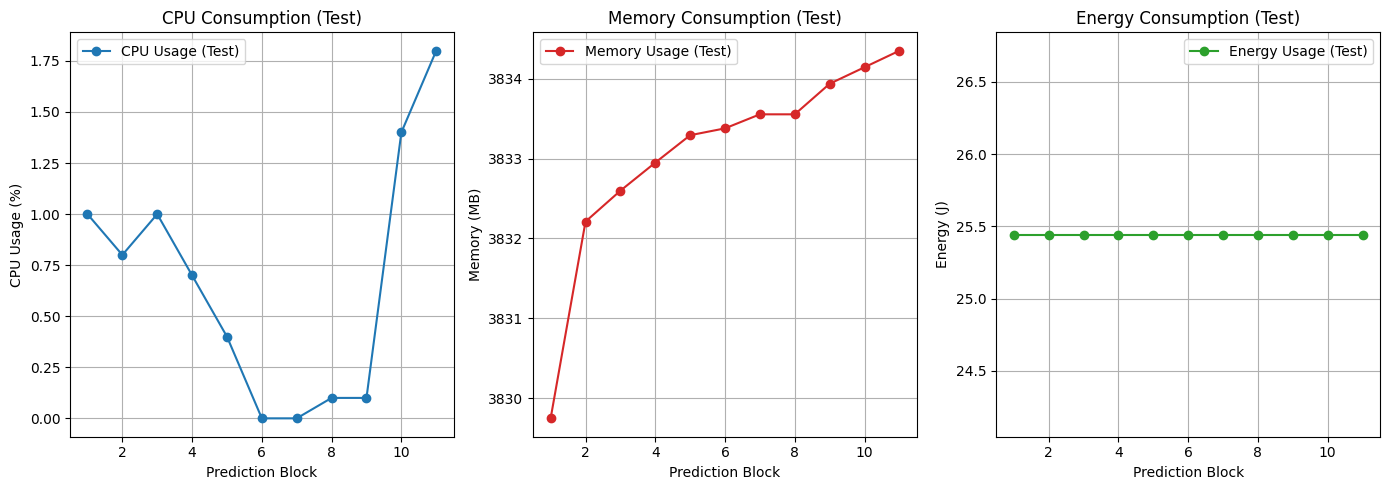

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.23 seconds
Average CPU usage (Test): 0.16%
Average memory usage (Test): 3766.09 MB
Estimated energy consumption: 0.078035 Joules


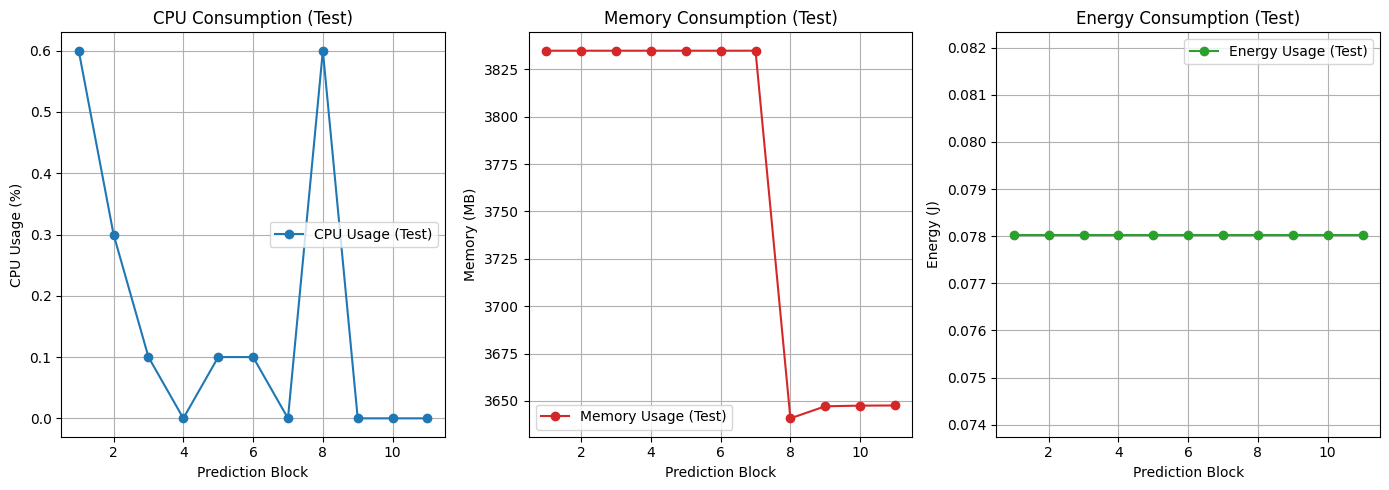


====== Zero-Day: SlowrateDoS ======

[Início do Treinamento]

[Epoch 1 - Início] CPU: 0.10%, Memory: 4122.58 MB
[Epoch 1 - Fim] CPU: 0.10%, Memory: 3895.28 MB, Energy: 0.16 J

[Epoch 2 - Início] CPU: 0.30%, Memory: 3895.29 MB
[Epoch 2 - Fim] CPU: 0.00%, Memory: 3917.29 MB, Energy: 0.00 J

[Epoch 3 - Início] CPU: 0.40%, Memory: 3917.29 MB
[Epoch 3 - Fim] CPU: 1.10%, Memory: 3939.97 MB, Energy: 637.24 J

[Epoch 4 - Início] CPU: 1.20%, Memory: 3939.96 MB
[Epoch 4 - Fim] CPU: 0.00%, Memory: 3943.09 MB, Energy: 0.00 J

[Epoch 5 - Início] CPU: 1.20%, Memory: 3943.08 MB
[Epoch 5 - Fim] CPU: 0.00%, Memory: 3952.80 MB, Energy: 0.00 J

[Epoch 6 - Início] CPU: 0.20%, Memory: 3952.79 MB
[Epoch 6 - Fim] CPU: 0.10%, Memory: 3961.83 MB, Energy: 0.96 J

[Epoch 7 - Início] CPU: 0.10%, Memory: 3961.83 MB
[Epoch 7 - Fim] CPU: 0.50%, Memory: 3969.73 MB, Energy: 140.21 J

[Epoch 8 - Início] CPU: 0.10%, Memory: 3969.72 MB
[Epoch 8 - Fim] CPU: 1.40%, Memory: 3981.07 MB, Energy: 3515.81 J

[Epoch 9 - Início]

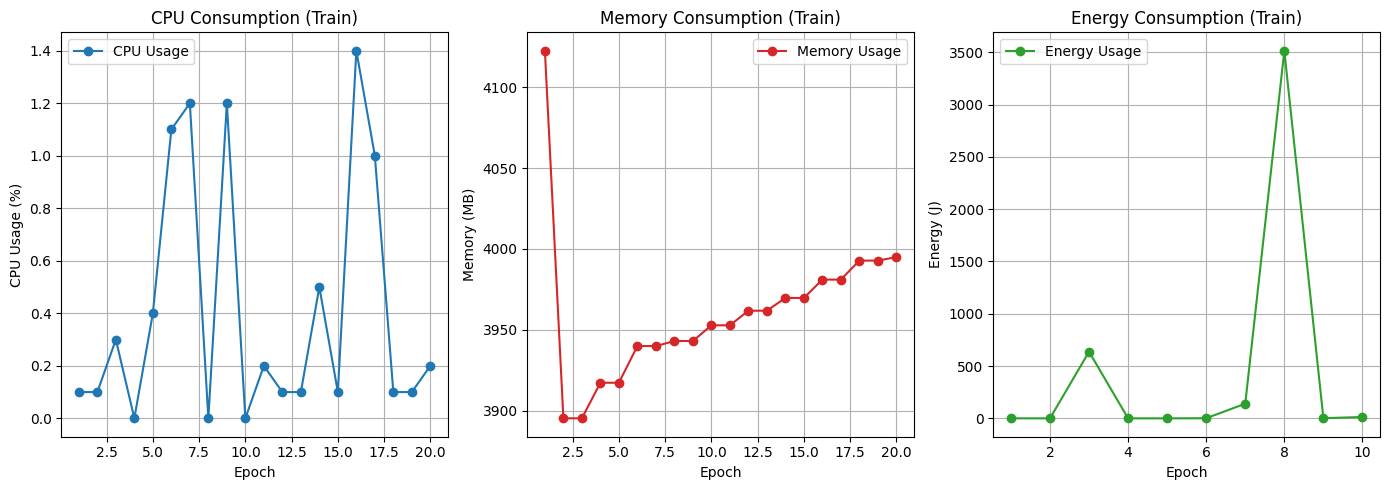

7600/7600 ━━━━━━━━━━━━━━━━━━━━ 6s 843us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 11.08 seconds
Average CPU usage (Test): 0.53%
Average memory usage (Test): 3809.58 MB
Estimated energy consumption: 12.997053 Joules


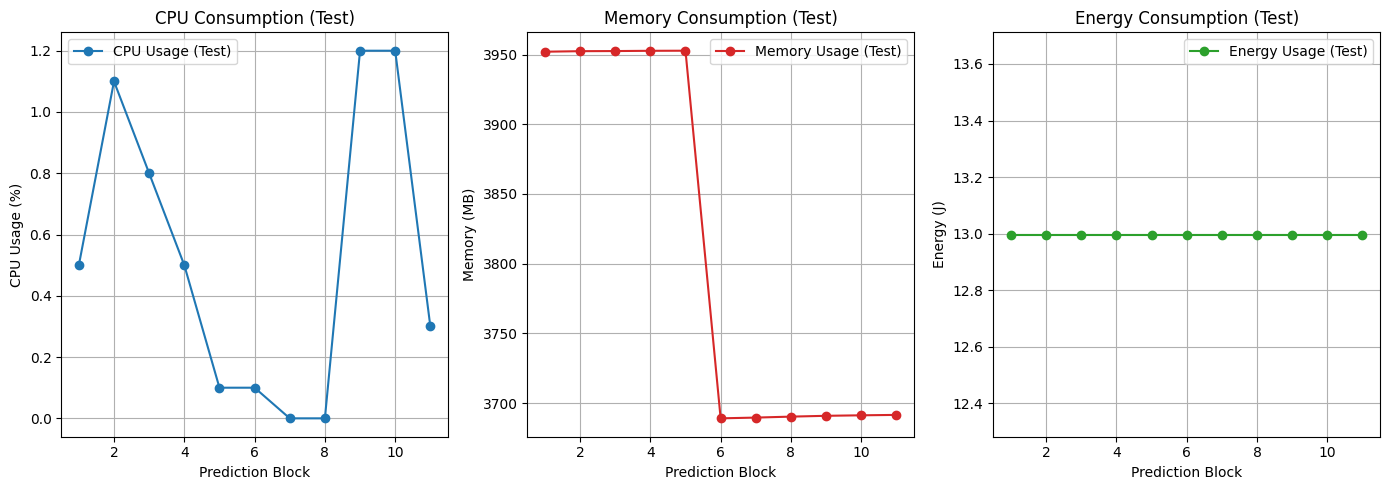

454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step

[Início da Predição/Teste]

[End of Prediction/Test]
Total time: 2.58 seconds
Average CPU usage (Test): 0.13%
Average memory usage (Test): 3696.89 MB
Estimated energy consumption: 0.042544 Joules


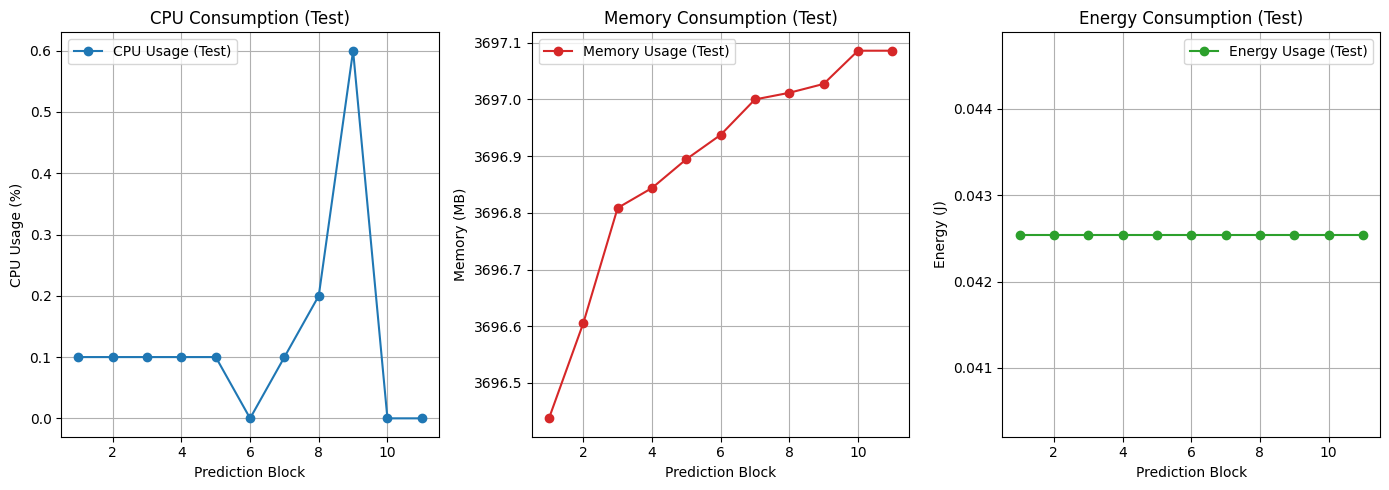

In [ ]:
# ===== IMPORTS =====
import pandas as pd
import numpy as np
import time
import psutil
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Configuração das features e rótulos
features = [
    'Seq', 'Offset', 'sTtl', 'tcp', 'AckDat', 'RST', 'INT', 'TcpRtt', 'icmp',
    'sMeanPktSz', 'FIN', 'sHops', 'Mean', 'dTtl', 'SrcBytes', 'TotBytes',
    'dMeanPktSz', 'Status', 'cs0', 'SrcWin', 'sTos', 'CON', 'REQ', 'Loss', 'Attack Type'
]

X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Dividir antes de escolher zero-days
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardar Attack Type para separar os zero-days
X_train['Attack Type'] = encoded.loc[X_train.index, 'Attack Type']
X_test['Attack Type'] = encoded.loc[X_test.index, 'Attack Type']

# ===== CONFIGURAÇÕES =====
zero_day_attacks = ['ICMPFlood', 'UDPFlood', 'SYNFlood', 'SYNScan', 'HTTPFlood', 'UDPScan', 'TCPConnectScan', 'SlowrateDoS']  # Adapte para os ataques que você quiser testar
smote = SMOTE(random_state=42)
scaler = StandardScaler()
label_encoder = LabelEncoder()

resultados_zero_day = []

# ===== LOOP PRINCIPAL =====
resultados_zero_day = []

for ataque_zero_day in zero_day_attacks:
    print(f"\n====== Zero-Day: {ataque_zero_day} ======")

    # --- Separação dos dados ---
    train_indices = X_train[X_train['Attack Type'] != ataque_zero_day].index
    test_indices = X_test[X_test['Attack Type'] == ataque_zero_day].index

    X_train_clean = X_train.loc[train_indices].drop(columns=['Attack Type'])
    y_train_clean = y_train.loc[train_indices]
    X_test_zero_day = X_test.loc[test_indices].drop(columns=['Attack Type'])
    y_test_zero_day = y_test.loc[test_indices]
    X_test_full = X_test.drop(columns=['Attack Type'])
    y_test_full = y_test

    # --- Balanceamento ---
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_clean, y_train_clean)
    X_train_balanced = scaler.fit_transform(X_train_balanced)
    X_test_full_scaled = scaler.transform(X_test_full)
    X_test_zero_day_scaled = scaler.transform(X_test_zero_day)

    y_train_balanced = label_encoder.fit_transform(y_train_balanced)
    y_test_full_encoded = label_encoder.transform(y_test_full)
    y_test_zero_day_encoded = label_encoder.transform(y_test_zero_day)

    # --- Construção do Modelo ---
    model = Sequential()
    model.add(Input(shape=(X_train_balanced.shape[1],)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # --- TREINAMENTO COM MONITORAMENTO ---
    start_time = time.time()
    history = model.fit(
        X_train_balanced, y_train_balanced,
        validation_split=0.2,
        epochs=10,
        batch_size=128,
        callbacks=[early_stopping, reduce_lr, resource_monitor],
        verbose=0
    )

    # --- TESTE GERAL COM MONITORAMENTO ---
    start_time = time.time()
    y_pred_full = model.predict(X_test_full_scaled).round()
    metrics_test_full = monitor_test_prediction(model, X_test_full_scaled)
    acc_teste_full = accuracy_score(y_test_full_encoded, y_pred_full)
    f1_teste_full = f1_score(y_test_full_encoded, y_pred_full, zero_division=1)
    precision_full = precision_score(y_test_full_encoded, y_pred_full, zero_division=1)
    recall_full = recall_score(y_test_full_encoded, y_pred_full, zero_division=1)


    # --- TESTE ZERO-DAY COM MONITORAMENTO ---
    start_time = time.time()
    y_pred_zero_day = model.predict(X_test_zero_day_scaled).round()
    metrics_zero_day = monitor_test_prediction(model, X_test_zero_day_scaled)
    acc_zero_day = accuracy_score(y_test_zero_day_encoded, y_pred_zero_day)
    f1_zero_day = f1_score(y_test_zero_day_encoded, y_pred_zero_day, zero_division=1)
    precision_zero = precision_score(y_test_zero_day_encoded, y_pred_zero_day, zero_division=1)
    recall_zero = recall_score(y_test_zero_day_encoded, y_pred_zero_day, zero_division=1)


    # --- Salvar resultados ---
    resultados_zero_day.append({
    'Ataque Zero-Day': ataque_zero_day,

    'Acurácia': acc_teste_full,
    'F1': f1_teste_full,
    'Precision': precision_full,
    'Recall': recall_full,
    'Tempo de Teste': metrics_test_full['total_time'],
    'CPU Teste': metrics_test_full['avg_cpu'],
    'Memória Teste': metrics_test_full['avg_mem'],
    'Energia Teste': metrics_test_full['energia'],

    'ZD - Acurácia': acc_zero_day,
    'ZD- F1': f1_zero_day,
    'ZD - Precision': precision_zero,
    'ZD - Recall': recall_zero,
    'ZD - Tempo de Teste': metrics_zero_day['total_time'],
    'ZD - CPU Teste': metrics_zero_day['avg_cpu'],
    'ZD - Memória Teste': metrics_zero_day['avg_mem'],
    'ZD - Energia Teste': metrics_zero_day['energia'],
})

    # --- Limpeza ---
    del model
    gc.collect()
    K.clear_session()

In [ ]:
!pip install tabulate

In [ ]:
import pandas as pd
from tabulate import tabulate

df_resultados = pd.DataFrame(resultados_zero_day)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 180)
pd.set_option('display.float_format', '{:.4f}'.format)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════════╤════════════╤══════════╤═════════════╤══════════╤══════════════════╤═════════════╤═════════════════╤═════════════════╤═════════════════╤══════════╤══════════════════╤═══════════════╤═══════════════════════╤══════════════════╤══════════════════════╤══════════════════════╕
│ Ataque Zero-Day   │   Acurácia │       F1 │   Precision │   Recall │   Tempo de Teste │   CPU Teste │   Memória Teste │   Energia Teste │   ZD - Acurácia │   ZD- F1 │   ZD - Precision │   ZD - Recall │   ZD - Tempo de Teste │   ZD - CPU Teste │   ZD - Memória Teste │   ZD - Energia Teste │
╞═══════════════════╪════════════╪══════════╪═════════════╪══════════╪══════════════════╪═════════════╪═════════════════╪═════════════════╪═════════════════╪══════════╪══════════════════╪═══════════════╪═══════════════════════╪══════════════════╪══════════════════════╪══════════════════════╡
│ ICMPFlood         │   0.997816 │ 0.998196 │    0.999544 │ 0.996852 │          10.7716 │    0.4      │         3240.45 │

In [ ]:
df_resultados.to_csv('resultados_zero_day_formatado.csv', index=False, float_format='%.4f')